# Vector Autoregression Model

### Introduction

Vector Autoregressive Models are used for multivariate time series similar to multiple linear regression. In multivariate time series analysis, it can be assumed that the variables not only depend on their past values, but also can be correlated with each other as well as the dependent variable. It allows for "feedback relationships" between all variables. All variables are all treated symetrically or 'endogenous' which are simply just variables that are influenced by other variables that are in the model. Predictor variables can influence the target variable AND the target can influence the predictors that's what it makes it difference from other autoregressive models.

- Dependent Variable: Zillow Home Value Index
- Independent Variables: `MORTGAGE30US`, `MedianCPI`, `HomesForSale`, `HomesSold`, `Unemployment`

The objective of the Vector Autoregression Model is to find which variables have a long term significant impact on the Dependent Variable and/or the long term statistically significant relationship on the Independent Variables. 

*How it works* 

- Each variable will have it's own equation comprising of the lags specified. 
- If the series is stationary, forecast by fitting a VAR to the data directly ("VAR in levels"). 
- If the series is not stationary, take differences until it is. Then, fit a VAR ("VAR in differences"). 
- The model is estimated by iterating through each equation by Ordinary Least Squares (OLS). The coefficients are estimated by minimizing the residual sum of squares (RSS).
- After the coefficients are estimated, forecasts are generated from the model in a recursive manner for each variable in the system. 

*How to choose the parameters*

- How many variables should I include?
    - Only ones that are correlated with each other. 
    - The more parameters that are included, the more computationally expensive it will be. 
    - If `K` is the number of parameters to include, and `p` is the number of lags, the number of coefficients to be estimated is equal to `K + pK^2`. 
    - In our case, we have K = 6, and p = 3, so 6 + (3 * 6^2) equals 114 coefficients to be estimated. 
    - The more coefficients that need to be estimated, the larger amount of error should be expected when making the forecast. 
    
- How to choose the number of lags?
    - The Baysian Information Criterion (BIC) should be used to select the number of lags. 

Sources:

- For educational background: 
    - [Forecasting: Principles and Practice Section 12.4](https://otexts.com/fpp3/VAR.html)
    - [PennState Eberly College of Science STAT 510 Applied Time Series Analysis 11.2](https://online.stat.psu.edu/stat510/lesson/11/11.2)
    - [Aptech Blog Introduction to the Fundamentals of Vector Autoregressive Models](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-vector-autoregressive-models/#:~:text=with%20VAR%20models.-,What%20is%20a%20vector%20autoregressive%20model%3F,other%20variables%20in%20the%20system.)
    
- For code: 
    - [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/)
    - [Machine Learning Plus](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)

### Import & Prepare Data

Import libraries. 

- `numpy`: In case we need to do any array or matrix math.
- `pandas`: To work with the dataframe.
- `matplotlib`: To plot visualizations. 
- `seaborn`: For prettier plots.

Note: Various models of the package `statsmodels` will be imported for use later in the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style = "darkgrid")

Import pickled dataframe.

In [2]:
full_df = pd.read_pickle('fulldataframe.pkl')

In [3]:
full_df.head()

,date,LosAngelesCA,NewYorkNY,RaleighNC,OklahomaCityOK,SaltLakeCityUT,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesUnemployment,NewYorkUnemployment,RaleighUnemployment,SaltLakeCityUnemployment,OklahomaCityUnemployment
0,2000-01-31,240598.0,226266.0,176753.0,91918.0,190020.0,8.25,2.785584,82.0,67.0,5.1,5.1,2.5,3.1,2.9
1,2000-02-29,241457.0,227618.0,176909.0,92156.0,190141.0,8.31,3.416809,79.0,78.0,5.1,5.0,2.6,3.4,3.0
2,2000-03-31,242727.0,228829.0,177351.0,92378.0,190386.0,8.23,2.276901,86.0,88.0,5.1,4.8,2.4,3.3,2.8
3,2000-04-30,245142.0,231213.0,178077.0,92742.0,190866.0,8.13,2.853534,80.0,78.0,5.1,4.1,2.0,2.9,2.2
4,2000-05-31,247707.0,233418.0,179033.0,93124.0,193543.0,8.62,3.142535,84.0,77.0,5.1,4.3,2.5,3.0,2.7


In [4]:
full_df.columns

Index(['date', 'LosAngelesCA', 'NewYorkNY', 'RaleighNC', 'OklahomaCityOK',
       'SaltLakeCityUT', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale',
       'HomesSold', 'LosAngelesUnemployment', 'NewYorkUnemployment',
       'RaleighUnemployment', 'SaltLakeCityUnemployment',
       'OklahomaCityUnemployment'],
      dtype='object')

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      275 non-null    datetime64[ns]
 1   LosAngelesCA              275 non-null    float64       
 2   NewYorkNY                 275 non-null    float64       
 3   RaleighNC                 275 non-null    float64       
 4   OklahomaCityOK            275 non-null    float64       
 5   SaltLakeCityUT            275 non-null    float64       
 6   MORTGAGE30US              275 non-null    float64       
 7   MedianCPI                 275 non-null    float64       
 8   HomesForSale              275 non-null    float64       
 9   HomesSold                 275 non-null    float64       
 10  LosAngelesUnemployment    275 non-null    float64       
 11  NewYorkUnemployment       275 non-null    float64       
 12  RaleighUnemployment   

Make a dataframe for each market area:

1. Los Angeles, California
2. New York City, New York
3. Raleigh, North Carolina
4. Oklahoma City, Oklahoma
5. Salt Lake City, Utah

In [6]:
LA_df = full_df[['date', 'LosAngelesCA', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 
                 'HomesSold', 'LosAngelesUnemployment']].copy()

In [7]:
LA_df.head()

,date,LosAngelesCA,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesUnemployment
0,2000-01-31,240598.0,8.25,2.785584,82.0,67.0,5.1
1,2000-02-29,241457.0,8.31,3.416809,79.0,78.0,5.1
2,2000-03-31,242727.0,8.23,2.276901,86.0,88.0,5.1
3,2000-04-30,245142.0,8.13,2.853534,80.0,78.0,5.1
4,2000-05-31,247707.0,8.62,3.142535,84.0,77.0,5.1


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Zillow Home Value Index'),
 Text(0.5, 1.0, 'Los Angeles')]

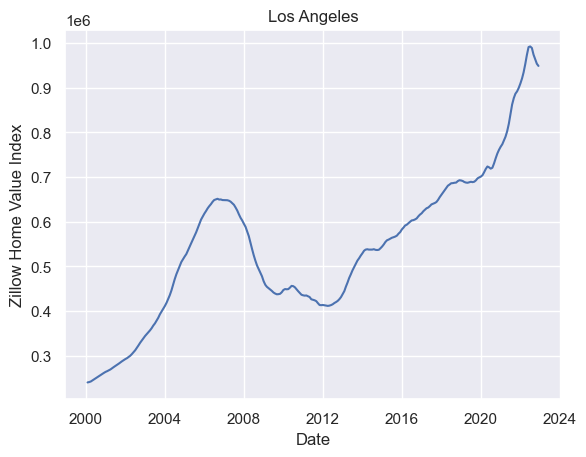

In [8]:
LA_timeseries = sns.lineplot(x = "date", y = "LosAngelesCA", data = LA_df)
LA_timeseries.set(xlabel = "Date", ylabel = "Zillow Home Value Index", title = "Los Angeles")

In [9]:
NYC_df = full_df[['date', 'NewYorkNY', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 
                  'HomesSold', 'NewYorkUnemployment']].copy()

In [10]:
NYC_df.head()

,date,NewYorkNY,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,NewYorkUnemployment
0,2000-01-31,226266.0,8.25,2.785584,82.0,67.0,5.1
1,2000-02-29,227618.0,8.31,3.416809,79.0,78.0,5.0
2,2000-03-31,228829.0,8.23,2.276901,86.0,88.0,4.8
3,2000-04-30,231213.0,8.13,2.853534,80.0,78.0,4.1
4,2000-05-31,233418.0,8.62,3.142535,84.0,77.0,4.3


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Zillow Home Value Index'),
 Text(0.5, 1.0, 'New York City')]

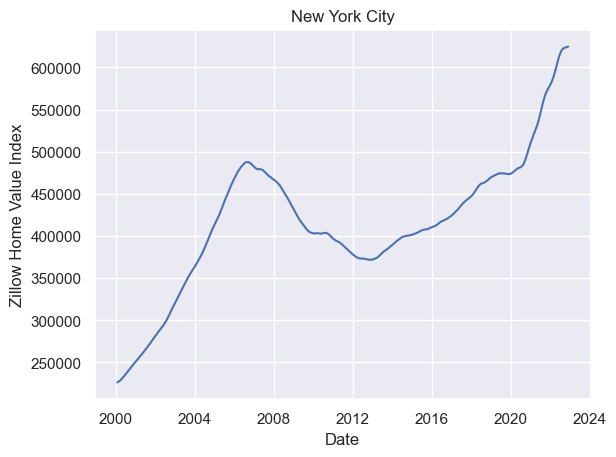

In [11]:
NYC_timeseries = sns.lineplot(x = "date", y = "NewYorkNY", data = NYC_df)
NYC_timeseries.set(xlabel = "Date", ylabel = "Zillow Home Value Index", title = "New York City")

In [12]:
NC_df = full_df[['date', 'RaleighNC', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 
                 'HomesSold', 'RaleighUnemployment']].copy()

In [13]:
NC_df.head()

,date,RaleighNC,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,RaleighUnemployment
0,2000-01-31,176753.0,8.25,2.785584,82.0,67.0,2.5
1,2000-02-29,176909.0,8.31,3.416809,79.0,78.0,2.6
2,2000-03-31,177351.0,8.23,2.276901,86.0,88.0,2.4
3,2000-04-30,178077.0,8.13,2.853534,80.0,78.0,2.0
4,2000-05-31,179033.0,8.62,3.142535,84.0,77.0,2.5


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Zillow Home Value Index'),
 Text(0.5, 1.0, 'Raleigh, North Carolina')]

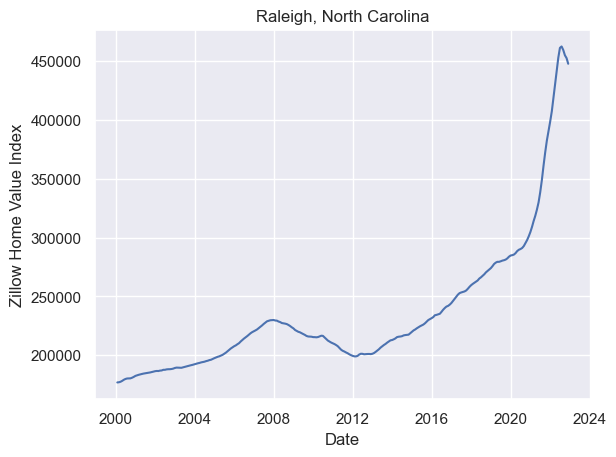

In [14]:
NC_timeseries = sns.lineplot(x = "date", y = "RaleighNC", data = NC_df)
NC_timeseries.set(xlabel = "Date", ylabel = "Zillow Home Value Index", title = "Raleigh, North Carolina")

In [15]:
OKC_df = full_df[['date', 'OklahomaCityOK', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 
                  'HomesSold', 'OklahomaCityUnemployment']].copy()

In [16]:
OKC_df.head()

,date,OklahomaCityOK,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,OklahomaCityUnemployment
0,2000-01-31,91918.0,8.25,2.785584,82.0,67.0,2.9
1,2000-02-29,92156.0,8.31,3.416809,79.0,78.0,3.0
2,2000-03-31,92378.0,8.23,2.276901,86.0,88.0,2.8
3,2000-04-30,92742.0,8.13,2.853534,80.0,78.0,2.2
4,2000-05-31,93124.0,8.62,3.142535,84.0,77.0,2.7


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Zillow Home Value Index'),
 Text(0.5, 1.0, 'Oklahoma City, Oklahoma')]

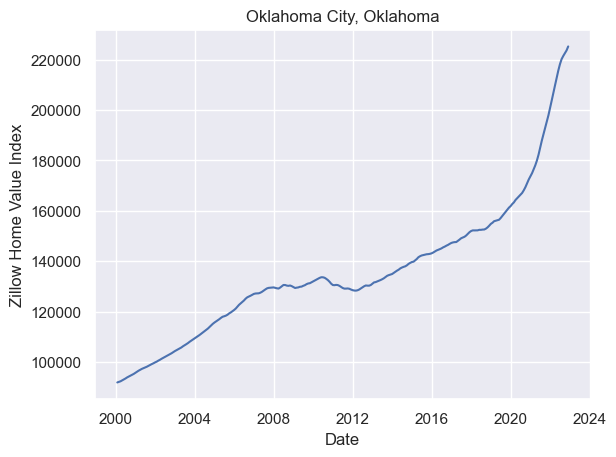

In [17]:
OKC_timeseries = sns.lineplot(x = "date", y = "OklahomaCityOK", data = OKC_df)
OKC_timeseries.set(xlabel = "Date", ylabel = "Zillow Home Value Index", title = "Oklahoma City, Oklahoma")

In [18]:
SLC_df = full_df[['date', 'SaltLakeCityUT', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 
                  'HomesSold', 'SaltLakeCityUnemployment']].copy()

In [19]:
SLC_df.head()

,date,SaltLakeCityUT,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,SaltLakeCityUnemployment
0,2000-01-31,190020.0,8.25,2.785584,82.0,67.0,3.1
1,2000-02-29,190141.0,8.31,3.416809,79.0,78.0,3.4
2,2000-03-31,190386.0,8.23,2.276901,86.0,88.0,3.3
3,2000-04-30,190866.0,8.13,2.853534,80.0,78.0,2.9
4,2000-05-31,193543.0,8.62,3.142535,84.0,77.0,3.0


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Zillow Home Value Index'),
 Text(0.5, 1.0, 'Salt Lake City, Utah')]

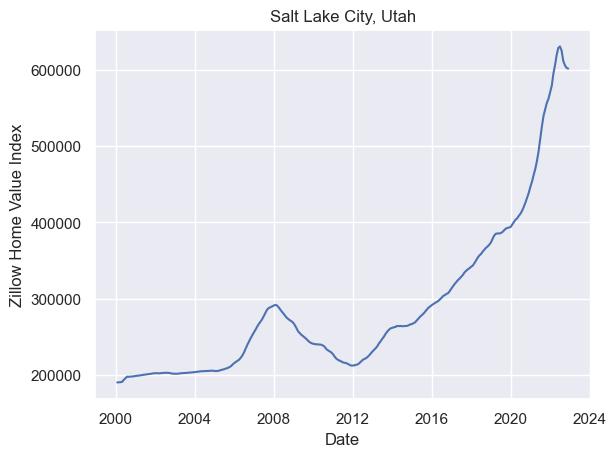

In [20]:
SLC_timeseries = sns.lineplot(x = "date", y = "SaltLakeCityUT", data = SLC_df)
SLC_timeseries.set(xlabel = "Date", ylabel = "Zillow Home Value Index", title = "Salt Lake City, Utah")

In [21]:
SLC_df.shape

(275, 7)

# Multivariate Time Series Analysis

In [22]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

**Step 1**: Visualize the time series to check for stationarity. Observe any trend, cyclic, seasonality behaviors.

In [23]:
SLC_df.set_index('date', inplace = True)

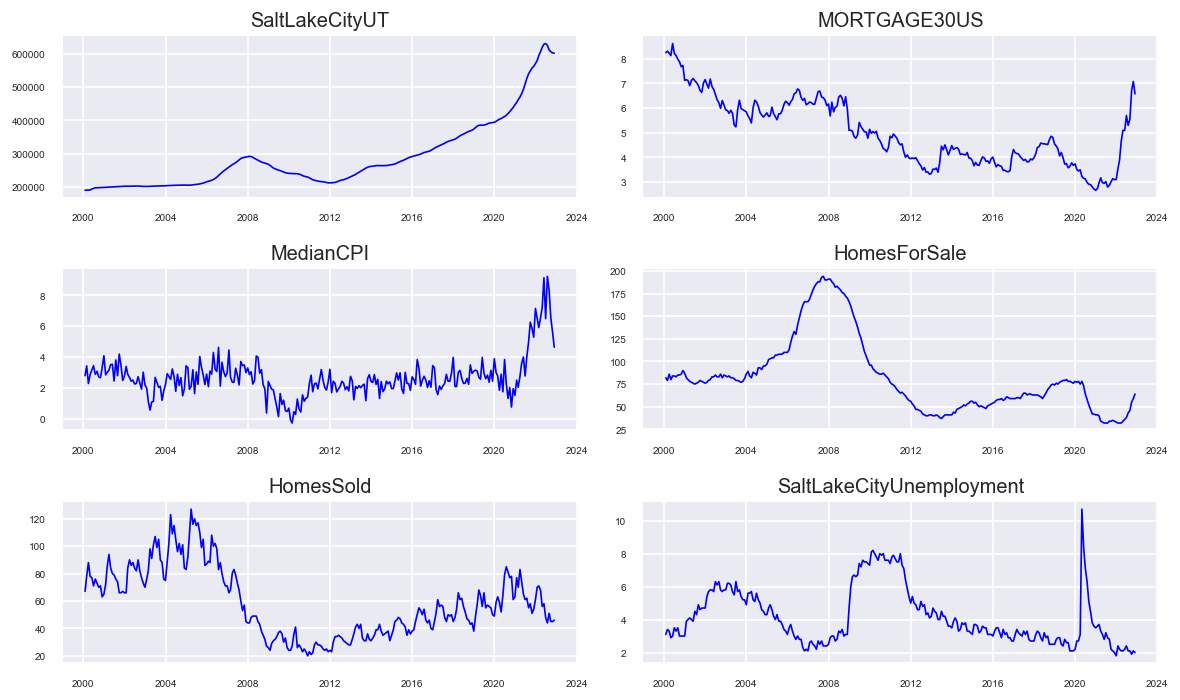

In [24]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, dpi = 120, figsize = (10,6))
for i, ax in enumerate(axes.flatten()):
    data = SLC_df[SLC_df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(SLC_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

`SLC_df` Observations:

- Zillow Home Value Index is the only variable showing distinct trend in a positive fashion.
- `MedianCPI` looks to be the closest to stationary, but is not. Showing signs of seasonality with a distinct shock around 2021. 
- `HomesSold` shows seasonality and follows a similar pattern to `HomesForSale` however that is smoother. 
- `SaltLakeCityUnemployment` shows cyclic behaviors with a spike in 2021. 

**Step 2**: Use the Augmented Dickey-Fuller Test to test for stationarity.

In [25]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag = 'BIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [26]:
for name, column in SLC_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SaltLakeCityUT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.2158
 No. Lags Chosen       = 12
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.9961. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MORTGAGE30US" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1832
 No. Lags Chosen       = 0
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.2124. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MedianCPI" 
    -----------------------------------------------
 Null Hypot

Note: All time series dependent and independent variables are Non-Stationary. We will need to use differencing to transform each time series stationary. 

**Step 3**: Test for cointegration to check for two or more time series in the dataset have a statistically long term relationship. The data needs to be non-stationary to perform this test. 

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(SLC_df)

Observations: The only variables indicating the precense of a statistically significant connect between two or more time series are the Zillow Home Value Index and the `Mortgage30US`. This indicates that we might only want our model to contain `Mortgage30US`.

**Step 4**: Make the time-series data stationary by taking the first difference. 

In [ ]:
df_differenced = SLC_df.diff().dropna()

Perform the ADF test to check if the time series data is stationary which was defined in Step 2.

In [ ]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Note: `HomesSold` is the only non-stationary time series. We need to take the second difference.

**Step 5**: Take the second difference.

In [ ]:
df_differenced = df_differenced.diff().dropna()

In [ ]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

**Step 6**: Test Causality using Granger's Causality Test. This test requires the data to be stationary.

Null Hypothesis: The past values of the time series (30 Year Fixed Mortage Rate, Median CPI, Homes for Sale, Homes Sold, Unemployment Rate) do not cause the other series (Zillow Home Value Index).

Alternative Hypothesis: They do influence the Zillow Home Value Index.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    
    for c in df.columns:
        
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df 

In [ ]:
grangers_causation_matrix(df_differenced, variables = df_differenced.columns)  

- What variables influence the Zillow Home Value Index in Salt Lake City?
    - `Mortgage30US`: 0.0126

**Step 7**: Split the data. 

In [ ]:
test_obs = 12
train = df_differenced[ : -test_obs]
test = df_differenced[-test_obs: ]

In [ ]:
print(train.shape)
print(test.shape)

**Step x**: Standardize the data.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
ct = ColumnTransformer(['standardize', StandardScaler(), ['LosAngelesCA', 'NewYorkNY', 'RaleighNC', 'OklahomaCityOK',
                        'SaltLakeCityUT', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale','HomesSold', 'LosAngelesUnemployment', 
                        'NewYorkUnemployment','RaleighUnemployment', 'SaltLakeCityUnemployment','OklahomaCityUnemployment']
                        ], remainder = 'passthrough')

In [ ]:
ct.fit_transform(full_df)

**Step 8**: Select the order `p` of the VAR `d` of 2 model ("VAR in differences").

In [ ]:
model = VAR(train)
x = model.select_order(maxlags=12)
x.summary()

According to [Forecasting Principles & Practice](https://otexts.com/fpp3/VAR.html), one should use BIC when evaluating a multivariate model so we will select order p 2. 

**Step 9**: Fit the model on order `p` of 2.

In [ ]:
result = model.fit(2)
result.summary()

**Step 10**: Check for Serial Coorelation of Residuals using Durbin Watson. 

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(result.resid)

for col, val in zip(train.columns, out):
    print(col, ':', round(val, 2))

Since all the values are close to 2, there is no significant serial correlation suggesting that all the variability is captured in the model.

**Step 11**: Forecast using VAR.

In [ ]:
# Get the lag order
lag_order = result.k_ar
print(lag_order)  

In [ ]:
# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

In [ ]:
pred = result.forecast(y = forecast_input, steps = test_obs)
df_forecast = pd.DataFrame(data = pred, index = train.index[-test_obs:], columns = train.columns + '_2d')
df_forecast

**Step 10**: Invert the differencing to get the real forecast.

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(train, df_forecast, second_diff=True)
df_results

**Step 11**: Plot forecasts.

In [ ]:
fig, axes = plt.subplots(nrows=int(len(SLC_df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(SLC_df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-test_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**Step 13**: Evaluate forecasts.

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [ ]:
accuracy_prod = forecast_accuracy(df_results['SaltLakeCityUT_forecast'].values, test['SaltLakeCityUT'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))